<h1><center><font color=blue>**Bringing Sanity to the Madness of March**</font></center></h1>
<h2><center>**Leading the March to Madness**</center></h2>
<h3><center>General Assembly Data Science Immersive Capstone Project</center></h3> 
<h4><center>Data and Description at https://www.kaggle.com/c/mens-machine-learning-competition-2018</center></h4>

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### All of the data with a couple of exceptions comes from the Google Cloud & NCAA Machine Learning 2018-Men's Basketball Tournament Competition.  Here we bring in all of the data that we will be using to help define our model.

In [2]:
df_tourney = pd.read_csv('./data/NCAATourneyCompactResults.csv')
df_season = pd.read_csv('./data/RegularSeasonDetailedResults.csv')
df_teams = pd.read_csv('./data/Teams.csv')
df_seeds = pd.read_csv('./data/NCAATourneySeeds.csv')
df_conferences = pd.read_csv('./data/Conferences.csv')
df_rankings = pd.read_csv('./data/MasseyOrdinals_thruSeason2018_Day128.csv')
df_sample_sub = pd.read_csv('./data/SampleSubmissionStage2.csv')
#df_sample_sub = pd.read_csv('./data/SampleSubmissionStage1.csv')

In [3]:
df_season.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [4]:
df_season.columns.values

array(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore',
       'WLoc', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA',
       'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA',
       'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO',
       'LStl', 'LBlk', 'LPF'], dtype=object)

#### The Regular Season Detailed Results dataset has information on every Regular Season game played since 2003. It shows the day the game was played (with DayNum = 1 being the very first game played for that particular season usually in late October/early November), the winning and losing teams, the scores of both teams as well as all the usual statistics assocated with basketball.  This includes stats like Field Goals Made/Attempted, Steals, Blocks, etc.  

#### In the next cell I will use NBA Analytics from the NBA Stuffer website from their Team Evaluation Metrics section: https://www.nbastuffer.com/analytics-101/  While the NBA and College games are different, the analytics stats would apply to the college game as well.

#### For Possession, we use their basic formula using the statistics that are found in the Season dataset.  I'm using their Basic Possession Formula:


$$Poss = 0.96[(FG_{Att}) + (TO) + 0.44(FT_{Att}) - OR]$$

In [5]:
wPos = df_season.apply(lambda row: 0.96*(row.WFGA + row.WTO + 0.44*row.WFTA - row.WOR), axis=1)
lPos = df_season.apply(lambda row: 0.96*(row.LFGA + row.LTO + 0.44*row.LFTA - row.LOR), axis=1)

# The following creates a new column for each game with the assumption that both teams have the same # of possessions
df_season['Possesions'] = (wPos+lPos)/2

#### The next cell calculates an efficiency rating (again used in the NBA) called the Player Impact Estimate (PIE) from http://www.rustylarue.com/more-than-94/player-efficiency-stats.  "PIE measures a player's overall statistical contribution against the total statistics in games they play in. Basically it is giving you a percentage showing how much of a positive or negative impact a player had on a game."

#### The formula for PIE for the entire team is:

$$PIE = \frac{Team(Pts Scored + FG_{Made} + FT_{Made} - FG_{Att} - FT_{Att} + DefReb + 0.5(OffReb) + Ast + Stl + 0.5(Blk) - PFouls - Turnovers)}{Total(Pts Scored + FG_{Made} + FT_{Made} - FG_{Att} - FT_{Att} + DefReb + 0.5(OffReb) + Ast + Stl + 0.5(Blk) - PFouls - Turnovers)}$$

In [6]:
wtmp = df_season.apply(lambda row: row.WScore + row.WFGM + row.WFTM - row.WFGA - row.WFTA + \
                       row.WDR + 0.5*row.WOR + row.WAst +row.WStl + 0.5*row.WBlk - row.WPF - row.WTO, axis=1)
ltmp = df_season.apply(lambda row: row.LScore + row.LFGM + row.LFTM - row.LFGA - row.LFTA + \
                       row.LDR + 0.5*row.LOR + row.LAst +row.LStl + 0.5*row.LBlk - row.LPF - row.LTO, axis=1) 

df_season['WPIE'] = wtmp/(wtmp + ltmp)
df_season['LPIE'] = ltmp/(wtmp + ltmp)

#### The next cells' calculations are what is called the Four Factors.  From https://www.nbastuffer.com/analytics101/four-factors/, "these factors identify a team's strategic strengths and weaknesses."

#### For Effective Field Goal Percentage, 

$$FG_{eff} = \frac{FG_{made} + 0.5(3PointFG_{made})}{FG_{att}}$$

In [7]:
df_season['WeFGP'] = df_season.apply(lambda row:(row.WFGM + 0.5 * row.WFGM3) / row.WFGA, axis=1)      
df_season['LeFGP'] = df_season.apply(lambda row:(row.LFGM + 0.5 * row.LFGM3) / row.LFGA, axis=1) 

#### Turnover Rate:

$$TO_{Rate} = \frac{TO}{FG_{Made} + 0.44(FT_{Att}) + TO}$$

In [8]:
df_season['WTOR'] = df_season.apply(lambda row: row.WTO / (row.WFGA + 0.44*row.WFTA + row.WTO), axis=1)
df_season['LTOR'] = df_season.apply(lambda row: row.LTO / (row.LFGA + 0.44*row.LFTA + row.LTO), axis=1)

#### Offensive Rebounding Percentage:

$$OffReb_{Percentage} = \frac{OR}{OR + DR_{opponent}}$$

In [9]:
df_season['WORP'] = df_season.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
df_season['LORP'] = df_season.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)

#### Free Throw Rate:

$$FT_{Rate} = \frac{FT_{Att}}{FG_{Att}} $$

In [10]:
df_season['WFTAR'] = df_season.apply(lambda row: row.WFTA / row.WFGA, axis=1)
df_season['LFTAR'] = df_season.apply(lambda row: row.LFTA / row.LFGA, axis=1)

#### Again, from https://www.nbastuffer.com/analytics101/four-factors/:

#### "While these are the four essential factors that decide to win and to lose in the NBA, the factors do not carry equal weight. Dean Oliver has found the following weights as follows:
1. Shooting (40%)
2. Turnovers (25%)
3. Rebounding (20%)
4. Free Throws (15%)

#### The number in parentheses is the approximate weight of each factor. Shooting is the most important factor, followed by turnovers, rebounding, and free throws. Each statistic measures a separate skill there’s no reason that a team can’t shoot well, commit few turnovers, rebound a high percentage of its misses and make frequent trips to the free throw line."

$$FourFactor = 0.4(FG_{Eff}) + 0.25(TO_{Rate}) + 0.20(OffReb_{Percentage}) + 0.15(FT_{Rate})$$

In [11]:
df_season['W4Factor'] = df_season.apply(lambda row: .40*row.WeFGP + .25*row.WTOR + .20*row.WORP + .15*row.WFTAR, axis=1)
df_season['L4Factor'] = df_season.apply(lambda row: .40*row.LeFGP + .25*row.LTOR + .20*row.LORP + .15*row.LFTAR, axis=1)

#### Offensive Efficiency (number of points scored per 100 possessions):

$$Off_{Eff} = 100(\frac{Score}{Poss})$$

In [12]:
df_season['WOffRtg'] = df_season.apply(lambda row: 100 * (row.WScore / row.Possesions), axis=1)
df_season['LOffRtg'] = df_season.apply(lambda row: 100 * (row.LScore / row.Possesions), axis=1)

#### Defensive Efficiency (number of points a team allows per 100 opposing team possessions):

$$Def_{Eff} = 100(\frac{Score}{Poss})$$

In [13]:
df_season['WDefRtg'] = df_season.LOffRtg
df_season['LDefRtg'] = df_season.WOffRtg

#### Assist Ratio (percentage of a team's possessions that ends in an assist:

$$Ast_{Ratio} = \frac{100(Ast)}{FG_{Att} + 0.44(FT_{Att}) + Ast + TO}$$

In [14]:
df_season['WAstR'] = df_season.apply(lambda row: 100 * row.WAst / (row.WFGA + 0.44*row.WFTA + row.WAst + row.WTO), axis=1)
df_season['LAstR'] = df_season.apply(lambda row: 100 * row.LAst / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)

#### Defensive Rebounding Percentage (team's ability to get defensive rebounds):

$$DR_{Percentage} = \frac{DR}{DR + OR}$$

In [15]:
df_season['WDRP'] = df_season.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
df_season['LDRP'] = df_season.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1) 

#### Free Throw Percentage:

$$FT_{Percentage} = \frac{FT_{Made}}{FT_{Att}}$$

In [16]:
df_season['WFTPCT'] = df_season.apply(lambda row : 0 if row.WFTA < 1 else row.WFTM / row.WFTA, axis=1)
df_season['LFTPCT'] = df_season.apply(lambda row : 0 if row.LFTA < 1 else row.LFTM / row.LFTA, axis=1)

#### Now we can drop all the columns that we no longer need.

In [17]:
df_season.drop(['WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'], axis=1, inplace=True)
df_season.drop(['LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'], axis=1, inplace=True)

#### Now we create a new DataFrame to calculate season totals for each of the statistics that we have just created. First up we calculate the winning percentage for each team.

In [18]:
df_season_composite = pd.DataFrame()


df_season_composite['WINS'] = df_season['WTeamID'].groupby([df_season['Season'], df_season['WTeamID']]).count()
df_season_composite['LOSSES'] = df_season['LTeamID'].groupby([df_season['Season'], df_season['LTeamID']]).count()
df_season_composite['WINPCT'] = df_season_composite['WINS'] / (df_season_composite['WINS'] + df_season_composite['LOSSES'])

#### Now we calculate averages for games teams won and lost adding them to the DataFrame

In [19]:
df_season_composite['WPIE'] = df_season['WPIE'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_composite['WeFGP'] = df_season['WeFGP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_composite['WTOR'] = df_season['WTOR'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_composite['WORP'] = df_season['WORP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_composite['WFTAR'] = df_season['WFTAR'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_composite['W4Factor'] = df_season['W4Factor'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_composite['WOffRtg'] = df_season['WOffRtg'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_composite['WDefRtg'] = df_season['WDefRtg'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_composite['WAstR'] = df_season['WAstR'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_composite['WDRP'] = df_season['WDRP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_composite['WFTPCT'] = df_season['WFTPCT'].groupby([df_season['Season'], df_season['WTeamID']]).mean()


df_season_composite['LPIE'] = df_season['LPIE'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_composite['LeFGP'] = df_season['LeFGP'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_composite['LTOR'] = df_season['LTOR'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_composite['LORP'] = df_season['LORP'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_composite['LFTAR'] = df_season['LFTAR'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_composite['L4Factor'] = df_season['L4Factor'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_composite['LOffRtg'] = df_season['LOffRtg'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_composite['LDefRtg'] = df_season['LDefRtg'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_composite['LAstR'] = df_season['LAstR'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_composite['LDRP'] = df_season['LDRP'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_composite['LFTPCT'] = df_season['LFTPCT'].groupby([df_season['Season'], df_season['LTeamID']]).mean()

#### Now we calculated a weighted average of each statistic using the winning percentage to weight the statistic

In [20]:
df_season_composite['PIE'] = df_season_composite['WPIE'] * df_season_composite['WINPCT'] + df_season_composite['LPIE'] * (1 - df_season_composite['WINPCT'])
df_season_composite['FG_PCT'] = df_season_composite['WeFGP'] * df_season_composite['WINPCT'] + df_season_composite['LeFGP'] * (1 - df_season_composite['WINPCT'])
df_season_composite['TURNOVER_RATE'] = df_season_composite['WTOR'] * df_season_composite['WINPCT'] + df_season_composite['LTOR'] * (1 - df_season_composite['WINPCT'])
df_season_composite['OFF_REB_PCT'] = df_season_composite['WORP'] * df_season_composite['WINPCT'] + df_season_composite['LORP'] * (1 - df_season_composite['WINPCT'])
df_season_composite['FT_RATE'] = df_season_composite['WFTAR'] * df_season_composite['WINPCT'] + df_season_composite['LFTAR'] * (1 - df_season_composite['WINPCT'])
df_season_composite['4FACTOR'] = df_season_composite['W4Factor'] * df_season_composite['WINPCT'] + df_season_composite['L4Factor'] * (1 - df_season_composite['WINPCT'])
df_season_composite['OFF_EFF'] = df_season_composite['WOffRtg'] * df_season_composite['WINPCT'] + df_season_composite['LOffRtg'] * (1 - df_season_composite['WINPCT'])
df_season_composite['DEF_EFF'] = df_season_composite['WDefRtg'] * df_season_composite['WINPCT'] + df_season_composite['LDefRtg'] * (1 - df_season_composite['WINPCT'])
df_season_composite['ASSIST_RATIO'] = df_season_composite['WAstR'] * df_season_composite['WINPCT'] + df_season_composite['LAstR'] * (1 - df_season_composite['WINPCT'])
df_season_composite['DEF_REB_PCT'] = df_season_composite['WDRP'] * df_season_composite['WINPCT'] + df_season_composite['LDRP'] * (1 - df_season_composite['WINPCT'])
df_season_composite['FT_PCT'] = df_season_composite['WFTPCT'] * df_season_composite['WINPCT'] + df_season_composite['LFTPCT'] * (1 - df_season_composite['WINPCT'])

df_season_composite.reset_index(inplace = True)

In [21]:
df_season_composite.head()

,Season,WTeamID,WINS,LOSSES,WINPCT,WPIE,WeFGP,WTOR,WORP,WFTAR,...,FG_PCT,TURNOVER_RATE,OFF_REB_PCT,FT_RATE,4FACTOR,OFF_EFF,DEF_EFF,ASSIST_RATIO,DEF_REB_PCT,FT_PCT
0,2003,1102,12,16.0,0.428571,0.755263,0.692162,0.182036,0.172188,0.541714,...,0.584407,0.193121,0.168235,0.446693,0.382694,109.413676,109.196437,17.806128,0.630384,0.642402
1,2003,1103,13,14.0,0.481481,0.615446,0.592604,0.155195,0.318510,0.554488,...,0.536564,0.159805,0.305803,0.465135,0.385508,116.646559,116.357791,15.919638,0.626998,0.735271
2,2003,1104,17,11.0,0.607143,0.657820,0.506056,0.160278,0.367049,0.392488,...,0.475785,0.167275,0.371256,0.372350,0.362236,108.962065,102.913066,13.098331,0.686897,0.705168
3,2003,1105,7,19.0,0.269231,0.641277,0.488400,0.197495,0.383144,0.425332,...,0.457983,0.207792,0.335166,0.359501,0.356100,98.566149,105.483276,13.828799,0.641434,0.709598
4,2003,1106,13,15.0,0.464286,0.741382,0.517668,0.220207,0.378952,0.395797,...,0.481697,0.213721,0.349480,0.307563,0.362140,98.671208,99.137679,12.652692,0.679342,0.623158


#### In 2014 and 2015, Kentucky and Wichita State went undefeated which creates null values in our new dataFrame since you can't calculate average statistics without Winning Percentage.  This is something that I've noticed several people have had to deal with when calculating overall team metrics.  We have to manually enter data for these missing columns.

In [22]:
df_season_composite[df_season_composite['LOSSES'].isnull()]

,Season,WTeamID,WINS,LOSSES,WINPCT,WPIE,WeFGP,WTOR,WORP,WFTAR,...,FG_PCT,TURNOVER_RATE,OFF_REB_PCT,FT_RATE,4FACTOR,OFF_EFF,DEF_EFF,ASSIST_RATIO,DEF_REB_PCT,FT_PCT
4064,2014,1455,33,NaN,NaN,0.697612,0.523191,0.137994,0.353977,0.479304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4211,2015,1246,34,NaN,NaN,0.809886,0.520134,0.137713,0.402745,0.451499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_season_composite.loc[4064,'WINPCT'] = 1
df_season_composite.loc[4064,'LOSSES'] = 0
df_season_composite.loc[4064,'PIE'] = df_season_composite.loc[4064,'WPIE']
df_season_composite.loc[4064,'FG_PCT'] = df_season_composite.loc[4064,'WeFGP']
df_season_composite.loc[4064,'TURNOVER_RATE'] = df_season_composite.loc[4064,'WTOR']
df_season_composite.loc[4064,'OFF_REB_PCT'] = df_season_composite.loc[4064,'WORP']
df_season_composite.loc[4064,'FT_RATE'] = df_season_composite.loc[4064,'WFTAR']
df_season_composite.loc[4064,'4FACTOR'] = df_season_composite.loc[4064,'W4Factor']
df_season_composite.loc[4064,'OFF_EFF'] = df_season_composite.loc[4064,'WOffRtg']
df_season_composite.loc[4064,'DEF_EFF'] = df_season_composite.loc[4064,'WDefRtg']
df_season_composite.loc[4064,'ASSIST_RATIO'] = df_season_composite.loc[4064,'WAstR']
df_season_composite.loc[4064,'DEF_REB_PCT'] = df_season_composite.loc[4064,'WDRP']
df_season_composite.loc[4064,'FT_PCT'] = df_season_composite.loc[4064,'WFTPCT']

df_season_composite.loc[4211,'WINPCT'] = 1
df_season_composite.loc[4211,'LOSSES'] = 0
df_season_composite.loc[4211,'PIE'] = df_season_composite.loc[4211,'WPIE']
df_season_composite.loc[4211,'FG_PCT'] = df_season_composite.loc[4211,'WeFGP']
df_season_composite.loc[4211,'TURNOVER_RATE'] = df_season_composite.loc[4211,'WTOR']
df_season_composite.loc[4211,'OFF_REB_PCT'] = df_season_composite.loc[4211,'WORP']
df_season_composite.loc[4211,'FT_RATE'] = df_season_composite.loc[4211,'WFTAR']
df_season_composite.loc[4211,'4FACTOR'] = df_season_composite.loc[4211,'W4Factor']
df_season_composite.loc[4211,'OFF_EFF'] = df_season_composite.loc[4211,'WOffRtg']
df_season_composite.loc[4211,'DEF_EFF'] = df_season_composite.loc[4211,'WDefRtg']
df_season_composite.loc[4211,'ASSIST_RATIO'] = df_season_composite.loc[4211,'WAstR']
df_season_composite.loc[4211,'DEF_REB_PCT'] = df_season_composite.loc[4211,'WDRP']
df_season_composite.loc[4211,'FT_PCT'] = df_season_composite.loc[4211,'WFTPCT']

#### Now we drop all but the final summary stats.

In [24]:
df_season_composite.drop(['WINS','WPIE','WeFGP','WTOR','WORP','WFTAR','W4Factor','WOffRtg','WDefRtg','WAstR','WDRP','WFTPCT'], axis=1, inplace=True)
df_season_composite.drop(['LOSSES','LPIE','LeFGP','LTOR','LORP','LFTAR','L4Factor','LOffRtg','LDefRtg','LAstR','LDRP','LFTPCT'], axis=1, inplace=True)

In [25]:
columns = list(df_season_composite.columns.values) 
columns.pop(columns.index('WINPCT')) 
columns.append('WINPCT')
df_season_composite = df_season_composite[columns]
df_season_composite.rename(columns={'WTeamID':'TeamID'}, inplace=True)
df_season_composite.head()

,Season,TeamID,PIE,FG_PCT,TURNOVER_RATE,OFF_REB_PCT,FT_RATE,4FACTOR,OFF_EFF,DEF_EFF,ASSIST_RATIO,DEF_REB_PCT,FT_PCT,WINPCT
0,2003,1102,0.488599,0.584407,0.193121,0.168235,0.446693,0.382694,109.413676,109.196437,17.806128,0.630384,0.642402,0.428571
1,2003,1103,0.509717,0.536564,0.159805,0.305803,0.465135,0.385508,116.646559,116.357791,15.919638,0.626998,0.735271,0.481481
2,2003,1104,0.536514,0.475785,0.167275,0.371256,0.372350,0.362236,108.962065,102.913066,13.098331,0.686897,0.705168,0.607143
3,2003,1105,0.415050,0.457983,0.207792,0.335166,0.359501,0.356100,98.566149,105.483276,13.828799,0.641434,0.709598,0.269231
4,2003,1106,0.527568,0.481697,0.213721,0.349480,0.307563,0.362140,98.671208,99.137679,12.652692,0.679342,0.623158,0.464286


#### The next statistic we want to add is called the Elo Rating found at the following:

- https://en.wikipedia.org/wiki/Elo_rating_system
- https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/
- https://github.com/fivethirtyeight/nfl-elo-game/blob/master/forecast.py


#### The Elo Rating System was "originally invented as an improved chess rating system, but is also used as a rating system for multiplayer competition" including basketball which is how we will use it.

#### The Elo Rating is calculated from the following:

$$
E_A = \frac{1}{1+10^{\frac{(R_B - R_A)}{400}}}
$$


$$
E_B = \frac{1}{1+10^{\frac{(R_A - R_B)}{400}}}
$$

#### where $R_A$ is Team A Rating
#### and $R_B$ is Team B Rating



#### Nates Silver's NBA Elo Algorithm  
#### Nate Silver has created his own Elo Algorithm for the NBA for the following:

#### Single Season:  

$$R_{0}=1300$$

$$R_{i+1}=K(S_{team}-E_{team})R_i$$ where R is Elo rating, $S$=1 if the team wins and $S=0$ for a loss. $E$ represents the expected win probability in Nate's formula and is defined as $$E_{\text{team}}=\frac{1}{1+10^{\frac{\text{opp_elo}-\text{team_elo}}{400}}}.$$ In chess K is a fixed constant but Nate changes K to handle margin of victory. Nate Silver's K is $$\text{K}=20\frac{(\text{MOV}_{winner}+3)^{0.8}}{7.5+0.006(\text{elo_difference}_{winner})}.$$ where $$\text{elo difference}_{winner}=\text{winning_elo}-\text{losing_elo}.$$ Nate also takes into account home advantage by increasing the rating of the home team by 100 as in $R_{\text{home}}=R_\text{team}+100$. 
The only other consideration is what to do in between seasons. Nate handles this by reverting each team towards a mean of 1505 as in the following formula $$R_{s=i+1}=(0.75)R_{s=i}+(0.25)1505.$$


#### The following code is taken from the following link:  

https://www.kaggle.com/lpkirwin/fivethirtyeight-elo-ratings

In [26]:
k = 20  # Based on FiveThirtyEight's calculation of NBA games
home_advantage = 100 # Adding 100 for teams playing at home

In [27]:
df_compact = pd.read_csv("./data/RegularSeasonCompactResults.csv")

In [28]:
team_ids = set(df_compact.WTeamID).union(set(df_compact.LTeamID))
len(team_ids)

364

In [29]:
# This dictionary will be used as a lookup for current
# scores while the algorithm is iterating through each game
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

In [30]:
# Elo updates will be scaled based on the margin of victory
df_compact['margin'] = df_compact.WScore - df_compact.LScore

In [31]:
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = k * mult * (1 - pred)
    return(pred, update)

In [32]:
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in df_compact.itertuples():
    
    # Get key data from current row
    w = row.WTeamID
    l = row.LTeamID
    margin = row.margin
    wloc = row.WLoc
    
    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0., 0.
    if wloc == "H":
        w_ad += home_advantage
    elif wloc == "A":
        l_ad += home_advantage
    
    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w] + w_ad,
                              elo_dict[l] + l_ad, 
                              margin)
    elo_dict[w] += update
    elo_dict[l] -= update
    
    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

In [33]:
df_compact['w_elo'] = w_elo
df_compact['l_elo'] = l_elo

In [34]:
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.WTeamID == team_id) | (d.LTeamID == team_id), :]
    d.sort_values(['Season', 'DayNum'], inplace=True)
    d.drop_duplicates(['Season'], keep='last', inplace=True)
    w_mask = d.WTeamID == team_id
    l_mask = d.LTeamID == team_id
    d['Season_ELO'] = None
    d.loc[w_mask, 'Season_ELO'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'Season_ELO'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'TeamID': team_id,  
        'Season': d.Season,
        'Season_ELO': d.Season_ELO
    })
    return(out)

In [35]:
df_list = [final_elo_per_season(df_compact, id) for id in team_ids]
season_elos = pd.concat(df_list)

In [36]:
season_elos = season_elos.reset_index(drop = True)

In [37]:
season_elos = season_elos.reindex(columns=['Season', 'TeamID', 'Season_ELO'])
#season_elos = season_elos.rename(columns = {'season':'Season', 'team_id':'TeamID', 'season_elo':'Season_ELO'})

In [38]:
season_elos.head()

,Season,TeamID,Season_ELO
0,2014,1101,1330.43
1,2015,1101,1215.48
2,2016,1101,1222.17
3,2017,1101,1238.54
4,2018,1101,1295.42


#### We bring in our Combined Metrics from Ken Pomeroy(https://kenpom.com/).  His end of season rankings are also included in the Massey Ordinals files supplied by Kaggle, but I don't use those here (as seen below).  He uses his own algorithm to calculate several team metrics including:

 - Adusted Efficiency Margin
 - Adjusted Offensive Efficiency
 - Adjusted Defensive Efficiency
 - Adjusted Temp (possessions per 40 minutes)
 - Luck Rating
 - Strength of Schedule Ratings for in-conference and non-conference play
 - Adjusted Offensive Efficieny of Opposing Offenses
 - Adjusted Defensive Efficiency of Opposing Defenses

#### The RPI rankings in the Massey file are empty for 2003 and 2004 so we start looking at data from 2005.

In [39]:
kenpom = pd.read_csv('./data/kenpom.csv')

In [40]:
season_composite = df_season_composite[(df_season_composite['Season'] >= 2005)]
season_elos = season_elos[(season_elos['Season'] >= 2005)]

In [41]:
df_season_composite = pd.merge(left=season_composite, right=kenpom, how='left', on=['Season', 'TeamID'])

In [42]:
df_season_composite = pd.merge(left=df_season_composite, right=season_elos, how='left', on=['Season', 'TeamID'])

In [43]:
df_season_composite.head()

,Season,TeamID,PIE,FG_PCT,TURNOVER_RATE,OFF_REB_PCT,FT_RATE,4FACTOR,OFF_EFF,DEF_EFF,...,AdjEM,AdjO,AdjD,AdjT,Luck,AdjEM_SOS,OppO_SOS,OppD_SOS,AdjEM_NCSOS,Season_ELO
0,2005,1102,0.581554,0.545641,0.157220,0.268673,0.286681,0.354298,114.739196,102.703017,...,13.40,112.2,98.9,54.3,-0.084,2.63,104.4,101.8,-1.50,1681.01
1,2005,1103,0.566102,0.518413,0.170315,0.305823,0.376753,0.367621,110.374878,102.159802,...,10.10,106.0,95.9,66.2,-0.014,2.55,105.7,103.2,-1.97,1593.4
2,2005,1104,0.662333,0.555191,0.167572,0.335826,0.466920,0.401172,119.497372,103.191905,...,20.51,118.8,98.3,62.8,0.033,6.84,106.5,99.6,-1.28,1895.52
3,2005,1105,0.542129,0.454552,0.178428,0.310825,0.450515,0.356170,98.001955,96.139165,...,-12.49,90.5,102.9,72.8,-0.023,-14.52,92.4,106.9,1.14,1325.6
4,2005,1106,0.463953,0.430332,0.204059,0.337985,0.460868,0.359875,93.206235,98.199491,...,-15.76,87.1,102.8,61.8,0.083,-12.85,93.7,106.6,1.14,1324.15


#### Let's look at a Heatmap of our features so far with the following observations:

1.  PIE and Winning Percentage are heavily correlated
2.  NBA Stuffer's Offensive Efficiency and Ken Pom's Adjusted Offensive Efficiency are correlated
3.  Strength of Schedule and Opponent Offensive Efficiency are correlated
4.  Strength of Schedule and Opponent Defensive Efficiency are negatively correlated

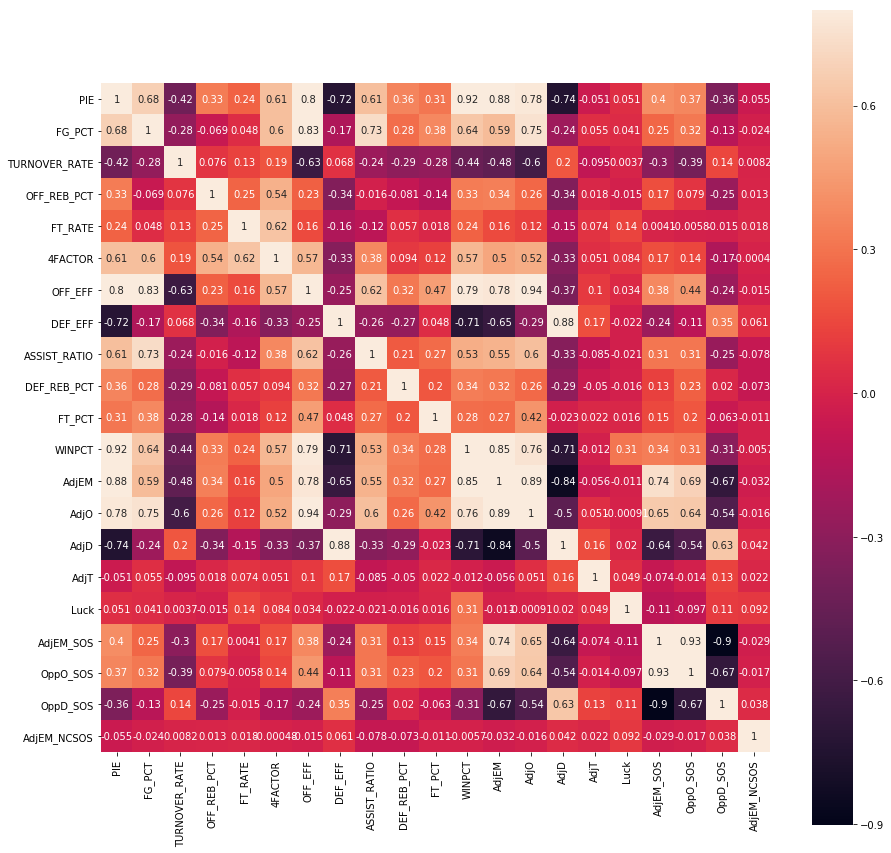

In [44]:
corrmatrix = df_season_composite.iloc[:, 2:].corr()

f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corrmatrix, vmax=.8, cbar=True, annot=True, square=True);

#### For Strength of Schedule, I will use the RPI ranking (https://en.wikipedia.org/wiki/Rating_percentage_index) of the teams before entering the tournament.

$$RPI = 0.25(WIN_{Percentage}) + 0.50(Win_{PercentageofOpp}) + 0.25(Win_{PercentageofOppOpp})$$

In [45]:
df_RPI = df_rankings[df_rankings['SystemName'] == 'RPI']
df_RPI_final = df_RPI[df_RPI['RankingDayNum'] == 128]
df_RPI_final.drop(labels=['RankingDayNum', 'SystemName'], inplace=True, axis=1)
df_RPI_final = df_RPI_final[(df_RPI_final['Season'] >= 2005)]
df_RPI_final.head()

C:\Users\aggie\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Season,TeamID,OrdinalRank
394034,2005,1102,112
394035,2005,1103,40
394036,2005,1104,13
394037,2005,1105,237
394038,2005,1106,249


#### Now we will get the seeds of the teams for all tournament games converting the seeds to integers.

In [46]:
df_seeds['seed_int'] = df_seeds['Seed'].apply( lambda x : int(x[1:3]) )
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) 
df_seeds.rename(columns={'seed_int':'Seed'},inplace=True)
df_seeds.head()

,Season,TeamID,Seed
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


#### Now we want to create a dataFrame of Team Features for all seasons.  Rankings started in 2003, but only have RPI data from 2005.

In [47]:
df_seeds_final = df_seeds[df_seeds['Season'] >= 2005]

df_tourney_stage = pd.merge(left=df_seeds_final, right=df_RPI_final, how='left', on=['Season', 'TeamID'])
df_tourney_final = pd.merge(left=df_tourney_stage, right=df_season_composite, how='left', on=['Season', 'TeamID'])

#### Now we want to generate a list of all the matchups in the tournament since 2013 (can go back to 2003 if I have the data)

In [48]:
df_tourney_list = pd.read_csv('./data/NCAATourneyCompactResults.csv')
df_tourney_list.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_tourney_list = df_tourney_list[df_tourney_list['Season'] >= 2005]
df_tourney_list.reset_index(inplace = True, drop=True)

#### Now we get the features from the winning and losing teams...

In [49]:
df_model_winners = pd.merge(left=df_tourney_list, right=df_tourney_final ,how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
df_model_winners.drop(labels=['TeamID'], inplace=True, axis=1)

df_model_losers = pd.merge(left=df_tourney_list, right=df_tourney_final ,how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
df_model_losers.drop(labels=['TeamID'], inplace=True, axis=1)

#### ...and generate the differences between winning and losing team features assigning 1 as the classifier for winning and 0 as the classifier for losing...

In [50]:
df_model_winner_diff = (df_model_winners.iloc[:, 3:] - df_model_losers.iloc[:, 3:])
df_model_winner_diff['result'] = 1
df_model_winner_diff = pd.merge(left=df_model_winner_diff, right=df_tourney_list, left_index=True, right_index=True, how='inner')

df_model_loser_diff = (df_model_losers.iloc[:, 3:] - df_model_winners.iloc[:, 3:])
df_model_loser_diff['result'] = 0
df_model_loser_diff = pd.merge(left=df_model_loser_diff, right=df_tourney_list, left_index=True, right_index=True, how='inner')

#### ...and combine them all to create a tourney predictions dataFrame.

In [51]:
df_predictions_tourney = pd.concat((df_model_winner_diff, df_model_loser_diff), axis=0)
df_predictions_tourney.sort_values('Season', inplace=True)
df_predictions_tourney.reset_index(inplace = True, drop=True)

In [52]:
df_predictions_tourney.head()

,Seed,OrdinalRank,PIE,FG_PCT,TURNOVER_RATE,OFF_REB_PCT,FT_RATE,4FACTOR,OFF_EFF,DEF_EFF,...,Luck,AdjEM_SOS,OppO_SOS,OppD_SOS,AdjEM_NCSOS,Season_ELO,result,Season,WTeamID,LTeamID
0,0,-18.0,-0.065855,0.052546,-0.023263,0.028533,-0.055467,0.012589,13.613617,19.954684,...,0.001,16.51,12.8,-3.7,13.23,131.501,1,2005,1324,1105
1,13,127.0,-0.031576,-0.073963,0.020017,-0.038345,0.071169,-0.021575,-18.781055,-8.788508,...,0.022,-14.34,-7.7,6.7,-6.81,-510.832,0,2005,1329,1368
2,15,215.0,-0.193842,-0.052560,-0.029080,-0.057046,-0.068337,-0.049954,-9.535419,19.756223,...,-0.033,-9.65,-3.5,6.1,10.11,-536.665,0,2005,1314,1324
3,-3,-55.0,-0.005031,-0.039170,-0.007003,0.045268,0.015982,-0.005968,-2.974829,-0.596986,...,0.104,-6.37,-3.4,2.9,2.08,-99.3099,0,2005,1301,1150
4,-1,9.0,-0.055364,-0.021140,-0.009435,-0.058021,-0.035476,-0.027740,-3.497655,2.884055,...,0.011,1.98,0.6,-1.3,5.98,-6.39604,0,2005,1280,1390


In [53]:
kenpom_missing = ~df_predictions_tourney['AdjEM'].isnull()
df_predictions_tourney = df_predictions_tourney[kenpom_missing].copy()

In [54]:
ordinalrank_missing = ~df_predictions_tourney['OrdinalRank'].isnull()
df_predictions_tourney = df_predictions_tourney[ordinalrank_missing].copy()

In [55]:
kenpom_missing = ~df_tourney_final['AdjEM'].isnull()
df_tourney_final = df_tourney_final[kenpom_missing].copy()

In [56]:
ordinalrank_missing = ~df_tourney_final['OrdinalRank'].isnull()
df_tourney_final = df_tourney_final[ordinalrank_missing].copy()

#### Now we are done with our features.  Time to start modeling in the next installment...!!!

In [ ]:
df_predictions_tourney.to_csv('./data/features.csv')

In [ ]:
df_tourney_final.to_csv('./data/df_tourney_final.csv')